In [1]:
import logging
from nltk import word_tokenize
import pandas as pd
import numpy as np
import gc
import os
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score
from torch import optim
import torchtext
import random
import matplotlib.pyplot as plt
import copy, time

In [2]:
text = torchtext.data.Field(lower=True, batch_first=True, tokenize=word_tokenize)
qid = torchtext.data.Field()

In [3]:
start = time.time()
target = torchtext.data.Field(sequential=False, use_vocab=False, is_target=True)
train = torchtext.data.TabularDataset(path='./data/Quora/train2.csv', format='csv',
                                      fields={'question_text': ('text',text),
                                              'target': ('target',target)})
test = torchtext.data.TabularDataset(path='./data/Quora/test.csv', format='csv',
                                     fields={'qid': ('qid', qid),
                                             'question_text': ('text', text)})
end = time.time()
print((end - start)/ 60)

1.2833078384399415


In [4]:
text.build_vocab(train, test, min_freq=3)
qid.build_vocab(test)
text.vocab.load_vectors(torchtext.vocab.
                        Vectors(r'C:\Users\Nikita\PycharmProjects\Sem_2\data\glove.6B.50d.txt'))

random.seed(2020)
train, val = train.split(split_ratio=0.9, random_state=random.getstate())

In [5]:
batch_size = 10

In [6]:
train_iter = torchtext.data.BucketIterator(dataset=train,
                                               batch_size=batch_size,
                                               sort_key=lambda x: x.text.__len__(),
                                               shuffle=True,
                                               sort=False)
val_iter = torchtext.data.BucketIterator(dataset=val,
                                             batch_size=batch_size,
                                             sort_key=lambda x: x.text.__len__(),
                                             train=False,
                                             sort=False)

In [7]:
step = 0
for train_batch in iter(train_iter):
    step += 1
for val_batch in iter(val_iter):
    step += 1
print(step)

35001


In [8]:
class BiLSTM(nn.Module):
    def __init__(self, pretrained_lm, padding_idx, static=True, hidden_dim=128, lstm_layer=2, dropout=0.2):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(p=dropout)
        self.embedding = nn.Embedding.from_pretrained(pretrained_lm)
        self.embedding.padding_idx = padding_idx
        if static:
            self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(input_size=self.embedding.embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=lstm_layer,
                            dropout=dropout,
                            bidirectional=True)
        self.hidden2label = nn.Linear(hidden_dim * lstm_layer * 2, 1)

    def forward(self, sents):
        x = self.embedding(sents)
        x = torch.transpose(x, dim0=1, dim1=0)
        lstm_out, (h_n, c_n) = self.lstm(x)
        y = self.hidden2label(self.dropout(torch.cat([c_n[i, :, :] for i in range(c_n.shape[0])], dim=1)))
        return y

In [9]:
class SimpleLSTM(nn.Module):
    def __init__(self, pretrained_lm, padding_idx,  hidden_dim=128, lstm_layer=2, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(pretrained_lm)
        self.embedding.padding_idx = padding_idx
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(input_size=self.embedding.embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=lstm_layer,)
        self.hidden2label = nn.Linear(hidden_dim * lstm_layer , 1)

    def forward(self, sents):
        x = self.embedding(sents)
        x = torch.transpose(x, dim0=1, dim1=0)
        lstm_out, (h_n, c_n) = self.lstm(x)
        cat = torch.cat([c_n[i, :, :] for i in range(c_n.shape[0])], dim=1)
        y = self.hidden2label(cat)
        return y

In [10]:
def load():
    m = torch.load('model.m')
    info = torch.load('model.info')
    return m, info
def save(m, info):
    torch.save(info, 'dm_model1.info')
    torch.save(m, 'dm_model1.m')

In [11]:
bilstm_model, bilstm_info = load()


In [12]:
def training(num_epochs, model, teacher_model, loss_func, optimizer, train_iter, val_iter):
    
    step = 0
    train_record = []
    val_record = []
     
    for epoch in range(num_epochs):
        tr_loss = []
        for train_batch in iter(train_iter):
            step += 1
            model.train()
            teacher_model.train()
            x = train_batch.text.cuda()
            y = train_batch.target.type(torch.Tensor).cuda()
            model.zero_grad()
            pred = model.forward(x)
            prob = teacher_model.forward(x).cuda()
            loss = loss_function(pred.view(-1), prob.view(-1), y)
            tr_loss.append(loss.cpu().data.numpy())
            loss.backward()
            optimizer.step()
            
            if step % 500 == 0 :
                model.eval()
                model.zero_grad()
                val_loss = []
                for val_batch in iter(val_iter):
                    
                    val_x = val_batch.text.cuda()
                    val_y = val_batch.target.type(torch.Tensor).cuda()
                    val_pred = model.forward(val_x).view(-1)
                    val_prob = teacher_model.forward(val_x).view(-1)
                    val_loss.append(loss_function(val_pred,val_prob, val_y).cpu().data.numpy())                    
                val_record.append({'step': step, 'loss': np.mean(val_loss)})
                train_record.append({'step': step, 'loss':  np.mean(tr_loss)})

                print('epoch {:02} - step {:06} - train_loss {:.4f} - val_loss {:.4f} '.format(
                    epoch, step,  train_record[-1]['loss'], val_record[-1]['loss']))
    save(m=model, info={'step': step, 'num_epochs': num_epochs, 'train_loss': train_record[-1]['loss'],
        'val_loss': val_record[-1]['loss'], 'tr_record':train_record,  'val_record':val_record})
     
    return train_record, val_record

In [13]:
def loss_function(output, prob, real_label):
    a = 0.5
    criterion_mse = torch.nn.MSELoss()
    criterion_bce = torch.nn.BCEWithLogitsLoss()
    return a*criterion_bce(output, real_label) + (1-a)*criterion_mse(output, prob)

In [14]:
LSTM_model = SimpleLSTM(text.vocab.vectors, lstm_layer=1, padding_idx=text.vocab.stoi[text.pad_token], 
                        hidden_dim=128).cuda()

In [15]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, LSTM_model.parameters()),
                    lr=0.002)

In [16]:
num_epochs = 3

In [17]:
start = time.time()

t_record, v_record = training(model=LSTM_model, teacher_model=bilstm_model, num_epochs=num_epochs, 
         loss_func=loss_function, optimizer=optimizer, train_iter=train_iter,
        val_iter=val_iter)

end = time.time()
print((end - start)/ 60)

epoch 00 - step 000500 - train_loss 3.0300 - val_loss 2.4937 
epoch 00 - step 001000 - train_loss 2.7387 - val_loss 2.7835 
epoch 00 - step 001500 - train_loss 2.3866 - val_loss 1.1440 
epoch 00 - step 002000 - train_loss 2.0457 - val_loss 1.1578 
epoch 00 - step 002500 - train_loss 1.8283 - val_loss 0.9066 
epoch 00 - step 003000 - train_loss 1.6791 - val_loss 0.8524 
epoch 00 - step 003500 - train_loss 1.5641 - val_loss 0.8488 
epoch 00 - step 004000 - train_loss 1.4712 - val_loss 0.7821 
epoch 00 - step 004500 - train_loss 1.3934 - val_loss 0.8233 
epoch 00 - step 005000 - train_loss 1.3330 - val_loss 0.7374 
epoch 00 - step 005500 - train_loss 1.2811 - val_loss 0.6829 
epoch 00 - step 006000 - train_loss 1.2316 - val_loss 0.6897 
epoch 00 - step 006500 - train_loss 1.1895 - val_loss 0.6422 
epoch 00 - step 007000 - train_loss 1.1530 - val_loss 0.6373 
epoch 00 - step 007500 - train_loss 1.1191 - val_loss 0.6233 
epoch 00 - step 008000 - train_loss 1.0886 - val_loss 0.6858 
epoch 00

epoch 02 - step 067000 - train_loss 0.3081 - val_loss 0.3477 
epoch 02 - step 067500 - train_loss 0.3082 - val_loss 0.3393 
epoch 02 - step 068000 - train_loss 0.3087 - val_loss 0.3346 
epoch 02 - step 068500 - train_loss 0.3090 - val_loss 0.3293 
epoch 02 - step 069000 - train_loss 0.3090 - val_loss 0.3293 
epoch 02 - step 069500 - train_loss 0.3090 - val_loss 0.3289 
epoch 02 - step 070000 - train_loss 0.3091 - val_loss 0.3857 
epoch 02 - step 070500 - train_loss 0.3099 - val_loss 0.3333 
epoch 02 - step 071000 - train_loss 0.3102 - val_loss 0.3305 
epoch 02 - step 071500 - train_loss 0.3105 - val_loss 0.3254 
epoch 02 - step 072000 - train_loss 0.3110 - val_loss 0.3300 
epoch 02 - step 072500 - train_loss 0.3114 - val_loss 0.3327 
epoch 02 - step 073000 - train_loss 0.3117 - val_loss 0.3629 
epoch 02 - step 073500 - train_loss 0.3116 - val_loss 0.3601 
epoch 02 - step 074000 - train_loss 0.3118 - val_loss 0.3476 
epoch 02 - step 074500 - train_loss 0.3117 - val_loss 0.3236 
epoch 02

C:\Users\Nikita\anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SimpleLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [18]:
t = [ t_record[i]['loss']  for i in range(len(t_record))]
v = [ v_record[i]['loss']  for i in range(len(t_record))]


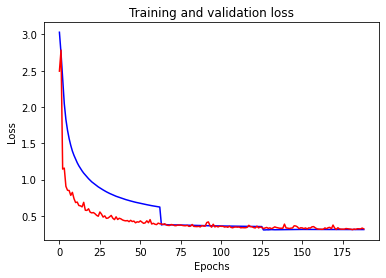

In [19]:
x = np.arange(0, len(t))
plt.plot(x, t, 'b', label='Training loss')
plt.plot(x, v, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [20]:
LSTM_model.eval()
val_pred = []
val_true = []
val_iter.init_epoch()
for val_batch in iter(val_iter):
    val_x = val_batch.text.cuda()
    val_true += val_batch.target.data.numpy().tolist()
    val_pred += torch.sigmoid(LSTM_model.forward(val_x).view(-1)).cpu().data.numpy().tolist()

In [22]:
tmp = [0,0,0] 
delta = 0
for tmp[0] in np.arange(0.01, 0.501, 0.001):
    tmp[1] = f1_score(val_true, np.array(val_pred)>tmp[0])
    if tmp[1] > tmp[2]:
        delta = tmp[0]
        tmp[2] = tmp[1]
print('best threshold is {:.4f} with F1 score: {:.4f}'.format(delta, tmp[2]))

best threshold is 0.2350 with F1 score: 0.6352
